In [1]:
import os
import sys
sys.path.append("../../../..")
from nebula.evaluation import read_cv_data_splits, read_cv_metrics_folder
from nebula.evaluation.roc import get_model_rocs, allign_metrics
from nebula.misc.plots import plot_roc_curves, plot_cv_metrics_dict
from nebula.models.attention import TransformerEncoderChunks
from nebula.misc import get_path
SCRIPT_PATH = get_path(type="notebook")
REPO_ROOT = os.path.join(SCRIPT_PATH, *[".."]*4)
import numpy as np
from collections import defaultdict
from pandas import DataFrame, concat
FPRS = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]

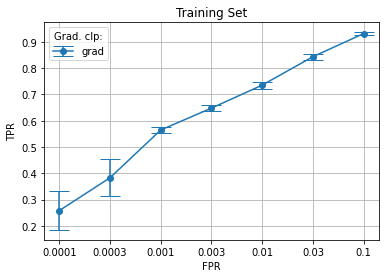

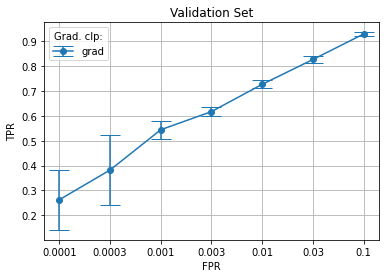

In [2]:
folder = "."
training_files = [x for x in os.listdir(folder) if x.endswith("training.json")]
validation_files = [x for x in os.listdir(folder) if x.endswith("validation.json")]

def training_filter(file):
    return file.endswith("training.json")
def validation_filter(file):
    return file.endswith("validation.json")
def key_extractor(file):
    return file.split("_")[4]

metrics_train = read_cv_metrics_folder('.', key_extractor, training_filter)
metrics_val = read_cv_metrics_folder('.', key_extractor, validation_filter)

TITLE = "Grad. update N. batches:"
newkeys = [x for x in metrics_train.keys()]
ax = plot_cv_metrics_dict(metrics_train, "tpr", legendTitle=TITLE, legendValues=newkeys)
ax.set_title("Training Set")

ax = plot_cv_metrics_dict(metrics_val, "tpr", legendTitle=TITLE, legendValues=newkeys)
_ = ax.set_title("Validation Set")

In [4]:
model_config = {
    "vocab_size": 50002,
    "maxlen": 512,
    "chunk_size": 64,
    "dModel": 64,
    "nHeads": 8,
    "dHidden": 256,
    "nLayers": 2,
    "numClasses": 1,
    "hiddenNeurons": [
        64
    ],
    "layerNorm": False,
    "dropout": 0.3,
    "mean_over_sequence": False
}

folder = os.path.join(SCRIPT_PATH, "..", "norm_first_limit_None_1677340681")
data_splits = read_cv_data_splits(folder)

roc_metrics_val = get_model_rocs(
    run_types=[1, 8 ,32], 
    model_class=TransformerEncoderChunks,
    model_config=model_config,
    data_splits=data_splits,
)

base_fpr_val, tprs_mean_val, tprs_std_val = allign_metrics(roc_metrics_val)

Model files:
	1: ['.\\training_files\\1677425659-model.torch', '.\\training_files\\1677426063-model.torch', '.\\training_files\\1677426448-model.torch']
	8: ['.\\training_files\\1677426852-model.torch', '.\\training_files\\1677427031-model.torch', '.\\training_files\\1677427213-model.torch']
	32: ['.\\training_files\\1677427400-model.torch', '.\\training_files\\1677427555-model.torch', '.\\training_files\\1677427710-model.torch']

Evaluating 1_split_0 | Size: 5397377...


100%|██████████| 397/397 [00:16<00:00, 23.39it/s]


Evaluating 1_split_1 | Size: 5397377...


100%|██████████| 397/397 [00:16<00:00, 24.10it/s]


Evaluating 1_split_2 | Size: 5397377...


100%|██████████| 397/397 [00:16<00:00, 24.06it/s]


Evaluating 8_split_0 | Size: 5397377...


100%|██████████| 397/397 [00:16<00:00, 23.48it/s]


Evaluating 8_split_1 | Size: 5397377...


100%|██████████| 397/397 [00:16<00:00, 23.93it/s]


Evaluating 8_split_2 | Size: 5397377...


100%|██████████| 397/397 [00:15<00:00, 25.53it/s]


Evaluating 32_split_0 | Size: 5397377...


100%|██████████| 397/397 [00:15<00:00, 25.46it/s]


Evaluating 32_split_1 | Size: 5397377...


100%|██████████| 397/397 [00:15<00:00, 25.74it/s]


Evaluating 32_split_2 | Size: 5397377...


100%|██████████| 397/397 [00:15<00:00, 24.86it/s]


,0.0001,0.0003,0.0010,0.0030,0.0100,0.0300,0.1000,0.3000
1,0.489433,0.685272,0.876801,0.933441,0.969758,0.986492,0.994810,0.998970
8,0.302792,0.427761,0.552926,0.626784,0.726080,0.824853,0.926537,0.979458
32,0.159991,0.273868,0.332679,0.378951,0.464265,0.560828,0.713662,0.913709


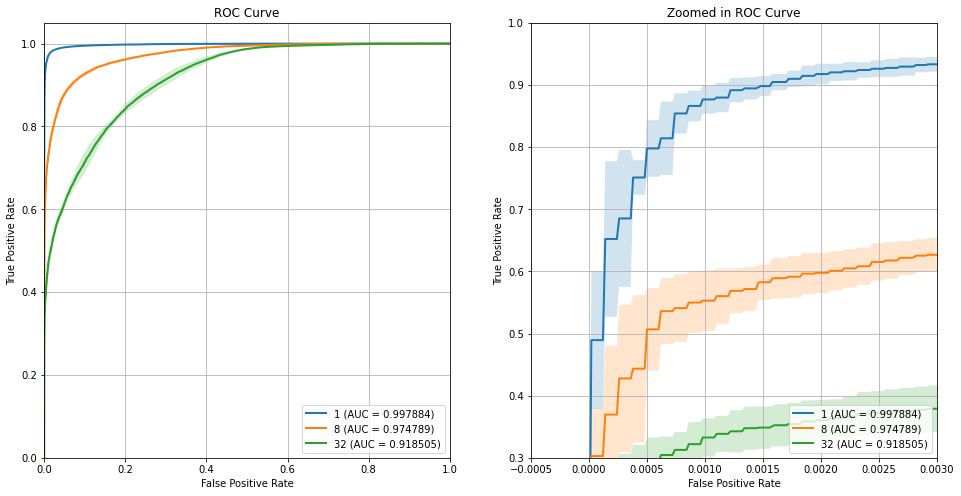

In [5]:
def report_metrics(base_fpr, tprs_mean, tprs_std, metrics, xlim=[-0.0005, 0.3], ylim=[0.6, 1]):
    tprsdf = DataFrame()
    for i, model_type in enumerate(tprs_mean.keys()):
        if i == 0:
            axs = None
        axs = plot_roc_curves(
            base_fpr, 
            tprs_mean[model_type], 
            tpr_std=tprs_std[model_type],
            model_name=f"{model_type}",
            axs=axs,
            roc_auc=metrics[model_type][0][2],
            xlim=xlim,
            ylim=ylim
        )
        tprs = defaultdict(list)
        for fpr in FPRS:
            tpr = tprs_mean[model_type][np.argmin(np.abs(base_fpr - fpr))]
            tprs[fpr].append(tpr)
        tprsdf = concat([tprsdf, DataFrame(tprs, index=[model_type])])
    [ax.grid() for ax in axs]
    _ = [ax.legend(loc='lower right') for ax in axs]
    return tprsdf

report_metrics(base_fpr_val, tprs_mean_val, tprs_std_val, roc_metrics_val, xlim=[-0.0005, 0.003], ylim=[0.3, 1.0])

## Test set ROCs

In [6]:
xtestpath = os.path.join(REPO_ROOT, r"data\data_filtered\speakeasy_testset_BPE_50k\speakeasy_vocab_size_50000_maxlen_512_x.npy")
X_test = np.load(xtestpath)
ytestpath = os.path.join(REPO_ROOT, r"data\data_filtered\speakeasy_testset_BPE_50k\speakeasy_y.npy")
y_test = np.load(ytestpath)

splits = 3
data_splits = [{"X_test": X_test, "y_test": y_test}]*splits

metrics = get_model_rocs(
    run_types=[1, 8, 32],
    model_class=TransformerEncoderChunks,
    model_config=model_config,
    data_splits=data_splits,
)

base_fpr, tprs_mean, tprs_std = allign_metrics(metrics)

Model files:
	1: ['.\\training_files\\1677425659-model.torch', '.\\training_files\\1677426063-model.torch', '.\\training_files\\1677426448-model.torch']
	8: ['.\\training_files\\1677426852-model.torch', '.\\training_files\\1677427031-model.torch', '.\\training_files\\1677427213-model.torch']
	32: ['.\\training_files\\1677427400-model.torch', '.\\training_files\\1677427555-model.torch', '.\\training_files\\1677427710-model.torch']

Evaluating 1_split_0 | Size: 5397377...


100%|██████████| 272/272 [00:11<00:00, 24.45it/s]


Evaluating 1_split_1 | Size: 5397377...


100%|██████████| 272/272 [00:11<00:00, 24.18it/s]


Evaluating 1_split_2 | Size: 5397377...


100%|██████████| 272/272 [00:11<00:00, 24.27it/s]


Evaluating 8_split_0 | Size: 5397377...


100%|██████████| 272/272 [00:11<00:00, 24.24it/s]


Evaluating 8_split_1 | Size: 5397377...


100%|██████████| 272/272 [00:11<00:00, 24.69it/s]


Evaluating 8_split_2 | Size: 5397377...


100%|██████████| 272/272 [00:11<00:00, 24.56it/s]


Evaluating 32_split_0 | Size: 5397377...


100%|██████████| 272/272 [00:11<00:00, 23.96it/s]


Evaluating 32_split_1 | Size: 5397377...


100%|██████████| 272/272 [00:11<00:00, 23.75it/s]


Evaluating 32_split_2 | Size: 5397377...


100%|██████████| 272/272 [00:11<00:00, 23.62it/s]


,0.0001,0.0003,0.0010,0.0030,0.0100,0.0300,0.1000,0.3000
1,0.170655,0.447410,0.537417,0.661030,0.755504,0.850970,0.896416,0.959091
8,0.025878,0.156191,0.273246,0.324046,0.386614,0.515864,0.715233,0.906023
32,0.024070,0.069659,0.130880,0.174022,0.255628,0.369138,0.530682,0.784927


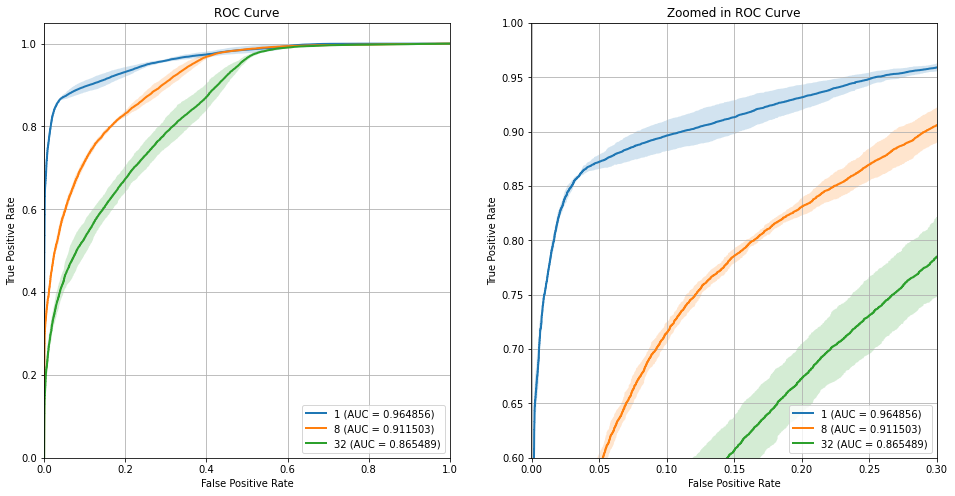

In [7]:
report_metrics(base_fpr, tprs_mean, tprs_std, metrics)